![Alt text: Slogan da Meteora.](https://i.imgur.com/VDYh2G1.png)

# 1. Estruturando a tabela

**Meteora** é uma loja que vende roupas e acessórios de diversas marcas por todos os estados do Brasil, para entender suas bases de dados e exibir informações relevantes com o objetivo de auxiliar suas tomadas de decisão.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import create_engine, inspect, text

**Sobre as tabelas**

* itens_pedidos: tabela que informa sobre o que foi vendido, vai ter informação o preço, quantidade, para onde vai ser enviado e o frete do pedido
* pedidos: vai falar sobre a venda feita, tendo informação sobre os vendedores, preço do pedido e a data da venda
* produtos: informa características dos produtos que são comercializados na loja
* vendedores: informa o nome dos vendedores.

In [2]:
url_itens_pedidos = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/itens_pedidos.csv'
url_pedidos = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/pedidos.csv'
url_produto = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/produtos.csv'
url_vendedores = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/vendedores.csv'

In [28]:
itens_pedidos = pd.read_csv(url_itens_pedidos)
pedidos = pd.read_csv(url_pedidos)
produtos = pd.read_csv(url_produto)
vendedores = pd.read_csv(url_vendedores)

In [29]:
# criação do banco de dados local
engine = create_engine('sqlite:///:memory:')

In [30]:
produtos.to_sql('produtos', engine, index=False)

205

In [31]:
itens_pedidos.to_sql('itens_pedidos', engine, index=False)
pedidos.to_sql('pedidos', engine, index=False)
vendedores.to_sql('vendedores', engine, index=False)

5

In [32]:
# verificar se as tabelas foram adicionadas ao banco de dados
inspector = inspect(engine)
print(inspector.get_table_names())

['itens_pedidos', 'pedidos', 'produtos', 'vendedores']


# 2. Primeiras consultas

Vamos entender a característica do produto que é comercializadora na Meteora, analisando a **condição** dos produtos vendidos.

In [33]:
query = 'SELECT CONDICAO FROM PRODUTOS'

In [34]:
with engine.connect() as conexao:
  consulta = conexao.execute(text(query))
  dados = consulta.fetchall()
pd.DataFrame(dados, columns = consulta.keys())

,Condicao
0,Usado
1,Usado
2,Usado
3,Usado
4,Usado
...,...
200,Usado
201,Usado
202,Usado
203,Usado


In [35]:
def sql_df(query):
  with engine.connect() as conexao:
    consulta = conexao.execute(text(query))
    dados = consulta.fetchall()

  return pd.DataFrame(dados, columns = consulta.keys())

In [38]:
query = '''SELECT CONDICAO, COUNT(*) AS 'Quantidade'
FROM PRODUTOS
GROUP BY CONDICAO;'''
df_produtos = sql_df(query)
df_produtos

,Condicao,Quantidade
0,Novo com etiqueta,22
1,Novo sem etiqueta,7
2,Usado,176


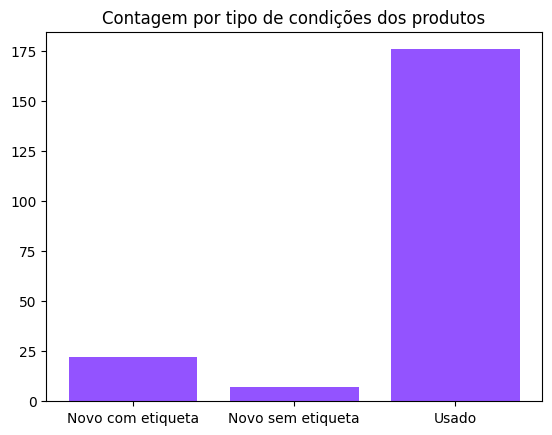

In [42]:
plt.bar(df_produtos['Condicao'], df_produtos['Quantidade'], color='#9353ff')
plt.title('Contagem por tipo de condições dos produtos')
plt.show()

Agora precisamos ranquear os produtos que mais foram pedidos por **quantidade** para entender a necessidade de um estoque de produtos na loja.

In [43]:
sql_df('SELECT * FROM PRODUTOS').head(3)

,produto_id,produto,preco,marca,sku,Condicao
0,21244,Oculos Lente Azulada,1120,D&g Dolce & Gabbana,209297,Usado
1,9981,Bolsa Coral Saco,4000,Givenchy,278612,Usado
2,84176,Camisa Xadrez Verde,310,Joe Fresh,322482,Usado


In [44]:
sql_df ('SELECT * FROM ITENS_PEDIDOS').head(3)

,id_nf,produto_id,pedido_id,quantidade,valor_unitario,valor_total,Estado,frete
0,1,41518,341,3,260,780,BR-BA,156.0
1,2,4307,1174,5,6175,30875,BR-RJ,6175.0
2,3,22407,1399,3,200,600,BR-PB,120.0


In [53]:
query = '''SELECT PRODUTOS.PRODUTO AS 'Produto', SUM(ITENS_PEDIDOS.QUANTIDADE) AS Quantidade
FROM ITENS_PEDIDOS
JOIN PRODUTOS
ON ITENS_PEDIDOS.PRODUTO_ID = PRODUTOS.PRODUTO_ID
GROUP BY PRODUTOS.PRODUTO
ORDER BY Quantidade ASC'''

df_prod_quantidade = sql_df(query)
df_prod_quantidade

,Produto,Quantidade
0,Vestido Malha Estampa,318
1,Blusa Listrada Malha,322
2,Blusa Malha Azul,325
3,Blusa Babados Off-white,337
4,Blusa Cinza,341
...,...,...
196,Saia Midi Cinto,549
197,Calca Alfaiataria Preta,750
198,Saia Pregas Preta,751
199,Calca Jeans Costuras,755


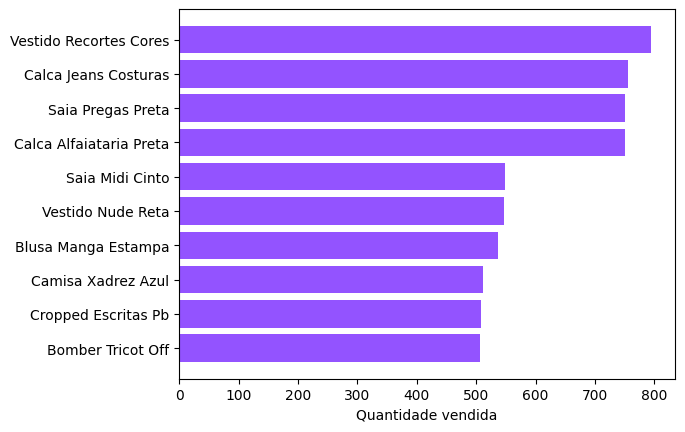

In [54]:
plt.barh(df_prod_quantidade['Produto'][-10:], df_prod_quantidade['Quantidade'][-10:], color='#9353ff')
plt.xlabel('Quantidade vendida')
plt.show()

## 2.1. Desafio #1

Esse primeiro desafio vai ser constituído de duas análises, a primeira tem por objetivo **calcular a receita total obtida com a venda de itens**. Na tabela itens_pedidos, o valor total dos itens representa o cálculo da quantidade pelo valor unitário e pode ser considerado como a receita da venda.

In [87]:
query = 'SELECT SUM(QUANTIDADE * VALOR_UNITARIO) AS RECEITA_TOTAL FROM ITENS_PEDIDOS'
df_receita_total = sql_df(query)
df_receita_total

,RECEITA_TOTAL
0,45803930


In [92]:
query = ''' SELECT PRODUTOS.PRODUTO AS Produto,
SUM(ITENS_PEDIDOS.quantidade * ITENS_PEDIDOS.valor_unitario) AS Total
FROM ITENS_PEDIDOS
JOIN PRODUTOS
ON ITENS_PEDIDOS.PRODUTO_ID = PRODUTOS.PRODUTO_ID
GROUP BY Produto
ORDER BY Total ASC'''

df_receita_por_produto = sql_df(query)
df_receita_por_produto

,Produto,Total
0,Vestido Estampa Laco,18630
1,Macaquinho Tricot Bege,20650
2,Top Cropped Coqueiros,31440
3,Shorts Poa Pb,35600
4,Shorts Estampa Floral,35640
...,...,...
196,Saia Couro Tijolo,1751800
197,Vestido Longo Preto,1814400
198,Sapato Cetim Pink,1821300
199,Bolsa Intrecciato Caramelo,2216825


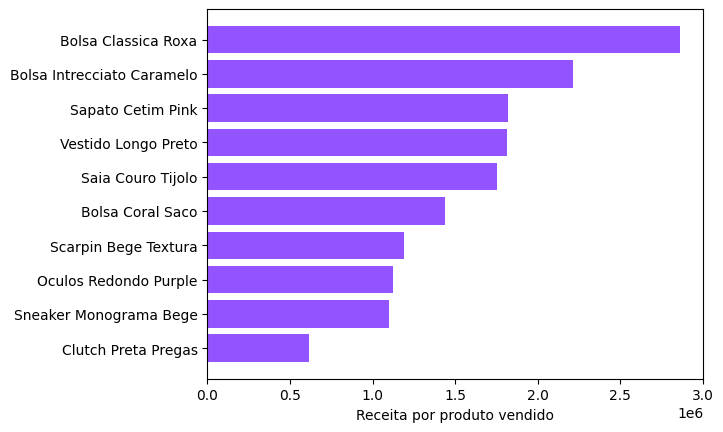

In [93]:
plt.barh(df_receita_por_produto['Produto'][-10:], df_receita_por_produto['Total'][-10:], color='#9353ff')
plt.xlabel('Receita por produto vendido')
plt.show()

## 2.2 Desafio #2

Já a segunda análise visa **identificar quais as 15 marcas que foram as mais pedidas por quantidades de venda**. Busque mostrar essa lista em uma visualização, além de expor o nome das marcas.

In [110]:
query = '''SELECT PRODUTOS.MARCA, COUNT(*) AS 'Pedidos'
FROM PRODUTOS
JOIN ITENS_PEDIDOS
ON ITENS_PEDIDOS.PRODUTO_ID = PRODUTOS.PRODUTO_ID
GROUP BY PRODUTOS.MARCA
ORDER BY COUNT(*) ASC
'''

df_top_15_marcas = sql_df(query)
df_top_15_marcas

,marca,Pedidos
0,Talie Nk,94
1,Track & Field,96
2,Ateliê de Calças,99
3,Bottega Veneta,101
4,Bcbgmaxzria,103
...,...,...
112,Banana Republic,584
113,Le Lis Blanc,715
114,Animale,1128
115,Mixed,1673


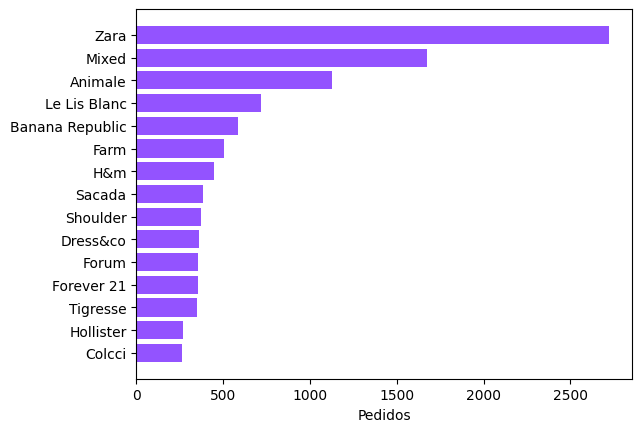

In [112]:
plt.barh(df_top_15_marcas['marca'][-15:], df_top_15_marcas['Pedidos'][-15:], color='#9353ff', )
plt.xlabel('Pedidos')
plt.show()

# 3. Lidando com filtro

Vamos iniciar uma análise de desempenho do **time de vendedores** da Meteora. A intenção aqui é entender como se deram as vendas dos vendedores no **ano anterior** para que possam ser aplicadas promoções e bônus salarial para a equipe no ano atual da tabela que é 2021

Para entender o desempenho de vendas dos vendedores no ano de 2020, é preciso trabalhar com os dados que estão presentes apenas no ano de 2020.

# 4. Avançando nas relações

A Meteora agora deseja incrementar as suas vendas no **estado de São Paulo (SP)**, por acreditar ser uma região mais propícia às vendas já que tem uma boa concentração de pessoas e mercado também.

Mas será que São Paulo já não rende muitas vendas em relação a outros estados?

Uma das ações que a Meteora pretende seguir para as vendas em SP é escolher dois de seus vendedores para que eles **foquem suas vendas** lá. Para essa escolha é interessante ter os profissionais que **mais tenham vendido** para as pessoas da região.